# Problem Statement
1. Download the Fashion_MNIST dataset. You can find it on the official Fashion-MNIST website or by using PyTorch's torchvision.datasets module. Split the dataset into training, validation and testing sets. A common split is 80% of the data to train, 10% to validate, and 10% to test scenarios, but you can adjust this as needed. Normalize the images. This involves scaling the pixel values to a range between 0 and 1.

2. Implement a MLP for classification. (total 40 marks)
    <ol type="a">
    <li>Flatten the images into a single dimensional vector before feeding it to the model. (1 marks)</li>
    <li>Write a pre-processing module for all the images. (3 marks)</li>
    <li>Write the Forward pass from scratch. Use of the inbuilt forward pass function will result in 0 marks for this sub-question. (8 marks)</li>
    <li>Write the Backward pass from scratch. Use the inbuilt back propagation function will result in 0 marks for this sub-question (12 marks)</li>
    <li>Write the module for cross entropy loss (1 marks)</li>
    <li>Experiment with different hyperparameters like number of layers, dropout, objective function, etc. and settle with a combination which performs the best for the given problem. (15 Marks)</li>
    </ol>

3. Implement a [CNN backbone model](https://www.baeldung.com/cs/neural-network-backbone) using pytorch. (total 40 marks)
    <ol type="a">
    <li>Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. (10 Marks )</li>
    <li>Experiment with different kernel size, number of kernel each layer (keep number of filter same in each layer, double it in each layer etc) and settle with a combination which performs the best for the given problem. (10 Marks)</li>
    <li>Try different weight initialization methods (random, Xavier, He) (5 Marks)</li>
    <li>After extracting feature from CNN model use MLP for classification (use code from question 2) (15 Marks)</li>
    </ol>

4. Submit a report clearly explaining how you have built the models, the architecture of the models, learning rate, epochs used for training, evaluation metrics and the instructions for running the models. Compare the performance of the models on the different hyperparameters you tried and justify the observed behavior. (20 Marks)

In [ ]:
# ==========================================================
# Import Dependencies
# ==========================================================

# for MLP
import gzip
import urllib.request
import numpy as np

# for Pytorch based backbone CNN
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor

# Miscellaneous
import os
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix


# Creating a logger object
logger = logging.getLogger()
# Setting log level
logger.setLevel(logging.INFO)

# Part 1 - Data Preparation

## Data Preparation (using pyTorch)
Downloaded the Fashion_MNIST dataset from PyTorch's `torchvision.datasets` module.

Split the training dataset (60,000 samples) into training (80%, i.e., 48,000 sample) and validation (20%, i.e., 12,000 samples) subsets. The testing dataset was already separate with 10,000 samples.

Used `transform=ToTensor()` to normalize the images by scaling the pixel values to a range between 0 and 1.

The dataset includes images of fashion items from following categories where the indexes in the list denotes the label values for corresponding categories:
0. T-shirt/Top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle Boot

Both the training and the testing datasets are saved using tensor with below dimensions:
1. Number of data samples (N) = 60,000 training data and 10,000 test data
2. Number of channels (C) = 1 channel for grayscale images
3. Height of the image (H) = 28 pixels for each image
4. Width of the image (W) = 28 pixels for each image

INFO:root:Training data size   : 48000
INFO:root:Validation data size : 12000
INFO:root:Test data size       : 10000
INFO:root:Shape of X [N, C, H, W] : torch.Size([64, 1, 28, 28])
INFO:root:Shape | Data-type of y  : torch.Size([64]) | torch.int64
INFO:root:Training Data Size: torch.Size([64, 1, 28, 28])
INFO:root:Total Training Data: 60000


<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([64, 1, 28, 28]) torch.Size([64])
labels:  Coat, Coat, Pullover, Bag, T-shirt/Top, Coat, Coat, Coat, Dress, Sneaker, Ankle Boot, T-shirt/Top, Pullover, Sneaker, Bag, Pullover, Dress, Ankle Boot, T-shirt/Top, Dress, Bag, Bag, Pullover, Coat, Sandal, Ankle Boot, Sneaker, Dress, Bag, Coat, Sandal, Pullover, Bag, Coat, Coat, Sandal, Coat, Pullover, Coat, Ankle Boot, Pullover, Shirt, Bag, Ankle Boot, Pullover, Ankle Boot, Pullover, T-shirt/Top, Pullover, T-shirt/Top, Coat, Sneaker, T-shirt/Top, T-shirt/Top, Pullover, Dress, Bag, Shirt, Trouser, Shirt, Shirt, Dress, Pullover, Coat, 

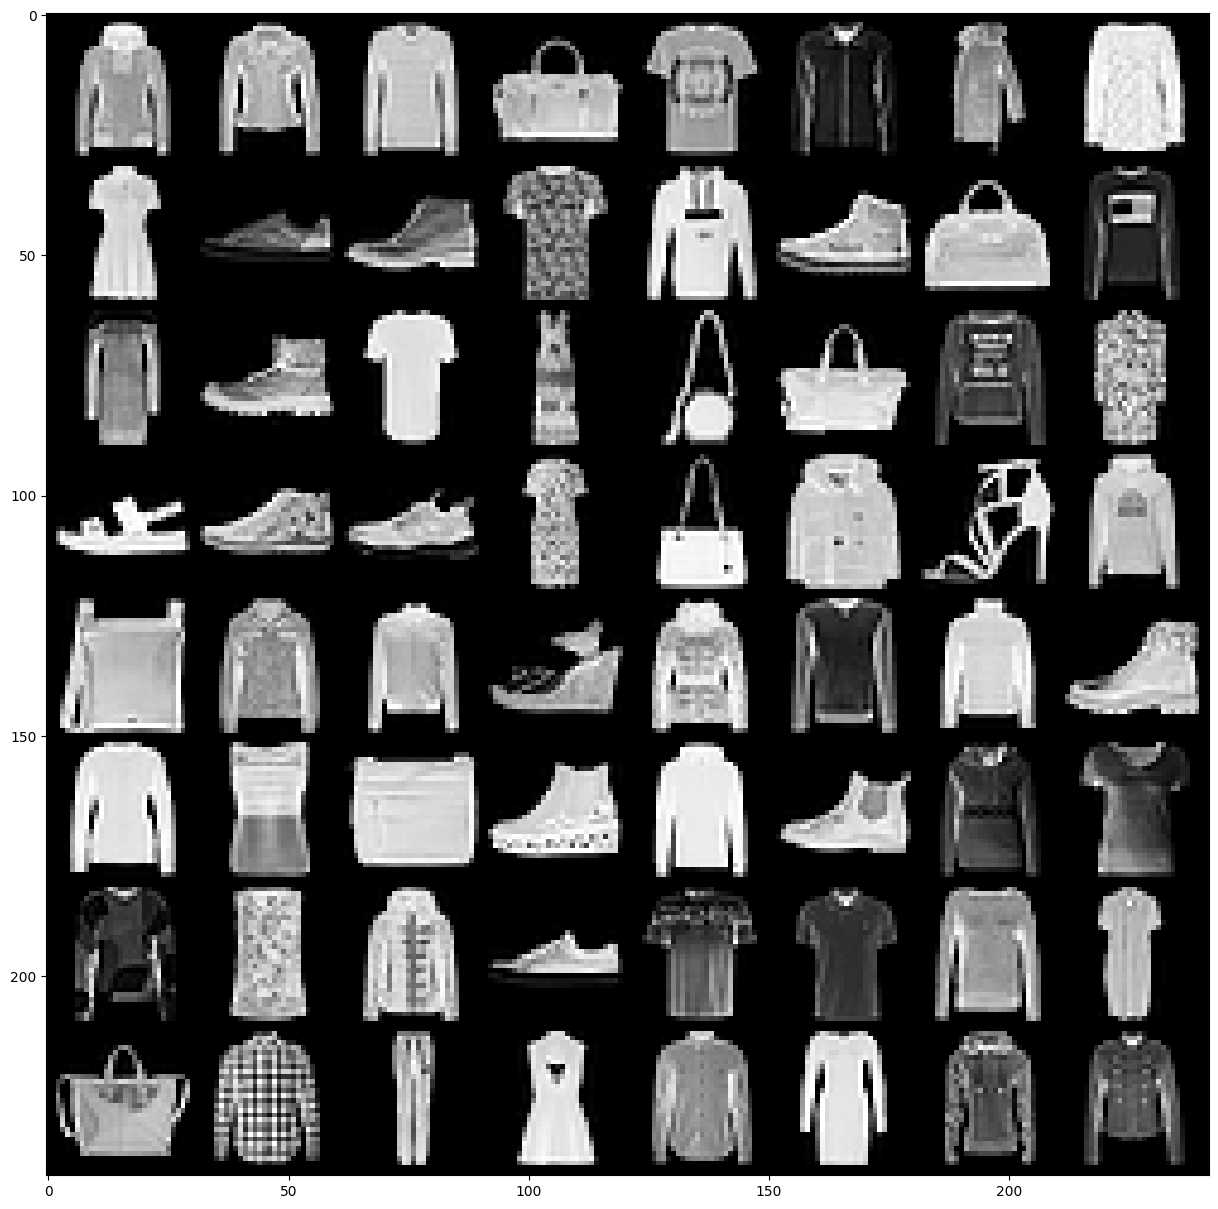

In [ ]:
# ==========================================================
# Data Preparation (using pyTorch)
# This dataset is used for CNN and CNN/MLP combined
# training, validation and testing
# ==========================================================

# Types of fashion items in the datasets
def image_label(label):
    IMAGE_LABEL_MAP = {
                 0: 'T-shirt/Top',
                 1: 'Trouser',
                 2: 'Pullover',
                 3: 'Dress',
                 4: 'Coat',
                 5: 'Sandal',
                 6: 'Shirt',
                 7: 'Sneaker',
                 8: 'Bag',
                 9: 'Ankle Boot'
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return IMAGE_LABEL_MAP[input]

# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),  # This transform normalizes data from [1, 255] to [0.0, 1.0]
)
# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),  # This transform normalizes data from [1, 255] to [0.0, 1.0]
)

# Split the training data into Training and Validation datasets
training_data_subset_size = int(0.8 * len(training_data))
validate_data_subset_size = len(training_data) - training_data_subset_size
training_data_subset, validation_data_subset = random_split(training_data, [training_data_subset_size, validate_data_subset_size])

logger.info(f'Training data size   : {len(training_data_subset)}')
logger.info(f'Validation data size : {len(validation_data_subset)}')
logger.info(f'Test data size       : {len(test_data)}')

# define batch-size to load data
batch_size = 64
# define num of epochs to be run for training
epochs = 10

# Create data loaders.
train_dataloader = DataLoader(training_data_subset, batch_size=batch_size)
validate_dataloader = DataLoader(validation_data_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    logger.info(f"Shape of X [N, C, H, W] : {X.shape}")
    logger.info(f"Shape | Data-type of y  : {y.shape} | {y.dtype}")
    break

# Shows different attributes and views of datasets
logger.info(f'Training Data Size: {(next(iter(train_dataloader)))[0].size()}')
logger.info(f'Total Training Data: {len(training_data)}')

# image, label = next(iter(train_dataset))
# plt.imshow(image.squeeze(), cmap='gray')
# logger.info(image_label(label))

batch = next(iter(train_dataloader))
train_images, train_labels = batch
print(type(train_images), type(train_labels))
print(train_images.shape, train_labels.shape)

grid = utils.make_grid(train_images, nrow=8)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print('labels: ', end=' ')
for i, label in enumerate(train_labels):
    print(image_label(label), end=', ')

## Data Preparation (using numpy)

Downloaded the Fashion_MNIST dataset from the official Fashion-MNIST website.

Split the training dataset (60,000 samples) into training (80%, i.e., 48,000 sample) and validation (20%, i.e., 12,000 samples) subsets. The testing dataset was already separate with 10,000 samples.

To normalize the images, scaled the pixel values to a range between 0 and 1 by dividing the values by 255.0.

Both the training and the testing datasets are saved as 2D matrices, with following dimensions:
1. Number of data samples (N) = 60,000 training data and 10,000 test data
2. Height * Width of the image (H * W) = 784 (28 * 28) pixels for each image

This dataset is used for standalone MLP training, validation and testing.

In [ ]:
# ==========================================================
# Data Preparation (Alternate using numpy)
# This dataset is used for standalone MLP training,
# validation and testing
# ==========================================================

# URL and data filename for the Fashion MNIST dataset
DATASET_BASE_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com'
DATASET_BASE_FOLDER = './data/FashionMNIST/raw'
DATA_FILENAME = {
    'train_images': 'train-images-idx3-ubyte.gz',
    'train_labels': 'train-labels-idx1-ubyte.gz',
    'test_images': 't10k-images-idx3-ubyte.gz',
    'test_labels': 't10k-labels-idx1-ubyte.gz'
}

# Helper function to download and extract the dataset
def download_and_extract(filename, is_image=False):
    if not os.path.exists('/'.join([DATASET_BASE_FOLDER, filename])):
        os.makedirs(DATASET_BASE_FOLDER, exist_ok=True)
        urllib.request.urlretrieve('/'.join([DATASET_BASE_URL, filename]),
                                   '/'.join([DATASET_BASE_FOLDER, filename]))
    filename = os.path.join(DATASET_BASE_FOLDER, filename)
    with gzip.open(filename, 'rb') as f:
        if (is_image):
            return np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28 * 28) / 255.0
        else:
            return np.frombuffer(f.read(), np.uint8, offset=8)

# Download and extract all files
train_images__np = download_and_extract(DATA_FILENAME['train_images'], is_image=True)
train_labels__np = download_and_extract(DATA_FILENAME['train_labels'])
test_images__np = download_and_extract(DATA_FILENAME['test_images'], is_image=True)
test_labels__np = download_and_extract(DATA_FILENAME['test_labels'])

# Split the training set into training and validation sets
num_train = int(0.8 * len(train_images__np))
train_data__np, val_data__np = train_images__np[:num_train], train_images__np[num_train:]
train_labels__np, val_labels__np = train_labels__np[:num_train], train_labels__np[num_train:]

logger.info(f'Training data shape   : Images - {train_data__np.shape} | Labels - {train_labels__np.shape}')
logger.info(f'Validation data shape : Images - {val_data__np.shape} | Labels - {val_labels__np.shape}')
logger.info(f'Test data shape       : Images - {test_images__np.shape} | Labels - {test_labels__np.shape}')

INFO:root:Training data shape   : Images - (48000, 784) | Labels - (48000,)
INFO:root:Validation data shape : Images - (12000, 784) | Labels - (12000,)
INFO:root:Test data shape       : Images - (10000, 784) | Labels - (10000,)


## Select Device for Executing the CNN/MLP Models

In [ ]:
# ==========================================================
# Select Device for Execution
# ==========================================================

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
logger.info(f"Using {device} device")

INFO:root:Using cuda device


# MLP Model for Classification

In [ ]:
# ==========================================================
# Define MLP Model for Classification
# ==========================================================

class DenseLayer:
    """
    Define a class to represent dense layer
    """
    def __init__(self, input_dim, output_dim, activation, lambda_reg=0.1, reg_type=None):
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases =  np.zeros((1, output_dim))
        logger.debug(f'weights: {self.weights.shape} | biases: {self.biases.shape}')

        self.activation_name = activation
        self.lambda_reg = lambda_reg

        self.output = None
        self.input = None

        self.reg_type = reg_type

        if self.activation_name == 'relu':
            self.activation = self.relu
            self.activation_prime = self.relu_prime
        elif self.activation_name == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_prime = self.sigmoid_prime
        elif self.activation_name == 'softmax':
            self.activation = self.softmax
            self.activation_prime = self.softmax_prime
        else:
            raise ValueError('activation function is not defined')

    def __str__(self):
        return f"""DenseLayer(input_dim:{self.input_dim}, output_dim:{self.output_dim}, activation:{self.activation_name})"""

    def forward(self, input_data):
        self.input = input_data
        logger.debug(f"self.input: {self.input.shape} \n self.weights {self.weights.shape}")
        Z = np.dot(self.input, self.weights) + self.biases
        logger.debug("Z ", Z.shape)
        self.output = self.activation(Z)
        logger.debug(f"set..... self.output {self.output.shape}")

        return self.output

    def backward(self, dA, learning_rate, y=None):
        """
        Backward propagate through this layer.
        dA is the derivative of the loss with respect to the output of this layer.
        y is the true labels, which is only needed if this is an output layer with softmax activation.
        """
        logger.debug(f"self.output {self.output.shape}")
        if self.activation_name == 'softmax':
            y_one_hot = np.zeros_like(self.output)
            y_one_hot[np.arange(len(y)), y] = 1
            # Calculate the derivative of the loss with respect to the softmax inputs
            logger.debug(len(y))
            logger.debug(self.output.shape)
            dZ = (self.output - y_one_hot)
            # logger.debug(f"before : {dZ.shape}, {dZ}")
            # dZ = dZ / len(y)                                                    # why divide????
            # logger.debug(f"after : {dZ.shape}, {dZ}")
        else:
            dZ = dA * self.activation_prime(self.output)

        dA_prev = np.dot(dZ, self.weights.T)
        dW = np.dot(self.input.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)

        if self.reg_type:
            if self.reg_type.upper() == "L1":
                 logger.debug("Using L1 regularization..")
                 weights_reg = self.lambda_reg * np.sign(self.weights)
                 biases_reg = self.lambda_reg * np.sign(self.biases)
            else:
                 logger.debug("Using L2 regularization....")
                 weights_reg = self.lambda_reg * self.weights
                 biases_reg = self.lambda_reg * self.biases
            self.weights -= learning_rate * (dW + weights_reg)
            self.biases -= learning_rate * (db + biases_reg)
        else:
            logger.debug("No regularization....")
            self.weights -= learning_rate * dW
            self.biases -= learning_rate * db

        return dA_prev

    # ==== Activation functions and their derivatives ====

    def relu(self, x):
        return np.maximum(0, x)

    def relu_prime(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    # Ref https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function
    def softmax(self,Z):
        exp_scores = np.exp(Z)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # Softmax activation

    # The derivative of the cross-entropy loss with respect to the input to the softmax is simply predictions - true_labels
    def softmax_prime(self,x):
        return None  # Not implemented as it's not used/required in current architecture


# Define a class to represent MLP
class MLP:
    def __init__(self):
        self.layers = []
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[]}

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self,output, learning_rate, y_train_batch):
        i = 0
        for layer in reversed(self.layers):
            # logger.trace(layer)
            logger.debug(f"{i}, =====================")
            i += 1
            output = layer.backward(output, learning_rate,y_train_batch)

    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)

    def cross_entropy_loss(self,y, output):
        m = y.shape[0]
        log_likelihood = -np.log(output[range(m), y] + 1e-9)
        loss = np.sum(log_likelihood) / m
        return loss

    def train(self, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=64, learning_rate=0.01):
        for epoch in range(epochs):
            permutation = np.random.permutation(train_data.shape[0])
            train_data = train_data[permutation]
            train_labels = train_labels[permutation]
            for i in range(0, train_data.shape[0], batch_size):
                X_batch = train_data[i:i+batch_size]
                y_batch = train_labels[i:i+batch_size]
                output = self.forward(X_batch)
                self.backward(output, learning_rate, y_batch)
            train_loss = self.cross_entropy_loss(train_labels, self.forward(train_data))
            self.history['train_loss'].append(train_loss)

            val_output = self.forward(val_data)
            val_loss = self.cross_entropy_loss(val_labels, val_output)  # Use val_labels directly
            self.history['val_loss'].append(val_loss)

            val_accuracy = np.mean(self.predict(val_data) == val_labels)
            train_acc = np.mean(self.predict(train_data) == train_labels)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_accuracy)
            logger.info(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    def test(self, test_data, test_labels, batch_size=64):
        test_output = self.forward(test_data)
        test_loss = self.cross_entropy_loss(test_labels, test_output)
        test_accuracy = np.mean(self.predict(test_data) == test_labels)
        logger.info(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    def show_plots(self):
        # Plot training vs validation loss
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Epoch vs Training/Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot training vs validation loss
        plt.plot(self.history['train_acc'], label='Training Accuracy')
        plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.title('Epoch vs Training/Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


# MLP - Model Training and Testing


INFO:root:Training the classification MLP model
INFO:root:Epoch 1, Training Loss: 0.6634, Validation Loss: 0.6656, Validation Accuracy: 0.7351
INFO:root:Epoch 2, Training Loss: 0.6077, Validation Loss: 0.6259, Validation Accuracy: 0.7412
INFO:root:Epoch 3, Training Loss: 0.6953, Validation Loss: 0.7229, Validation Accuracy: 0.7318
INFO:root:Epoch 4, Training Loss: 0.5885, Validation Loss: 0.6125, Validation Accuracy: 0.8005
INFO:root:Epoch 5, Training Loss: 0.4378, Validation Loss: 0.4602, Validation Accuracy: 0.8388
INFO:root:Epoch 6, Training Loss: 0.4420, Validation Loss: 0.4721, Validation Accuracy: 0.8255
INFO:root:Epoch 7, Training Loss: 0.4144, Validation Loss: 0.4506, Validation Accuracy: 0.8416
INFO:root:Epoch 8, Training Loss: 0.5168, Validation Loss: 0.5539, Validation Accuracy: 0.7789
INFO:root:Epoch 9, Training Loss: 0.4478, Validation Loss: 0.4905, Validation Accuracy: 0.8001
INFO:root:Epoch 10, Training Loss: 0.3935, Validation Loss: 0.4485, Validation Accuracy: 0.8448
I

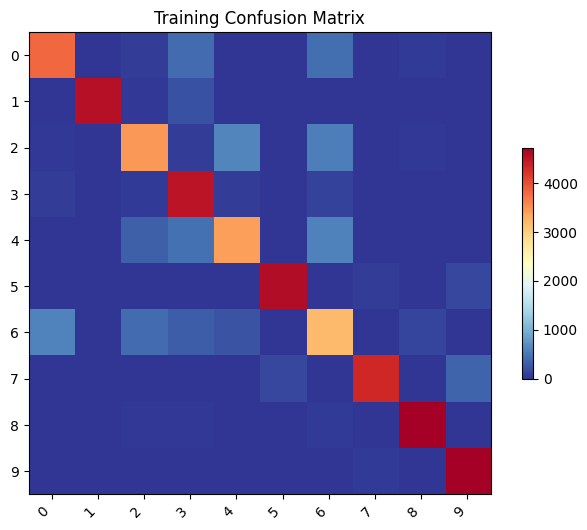

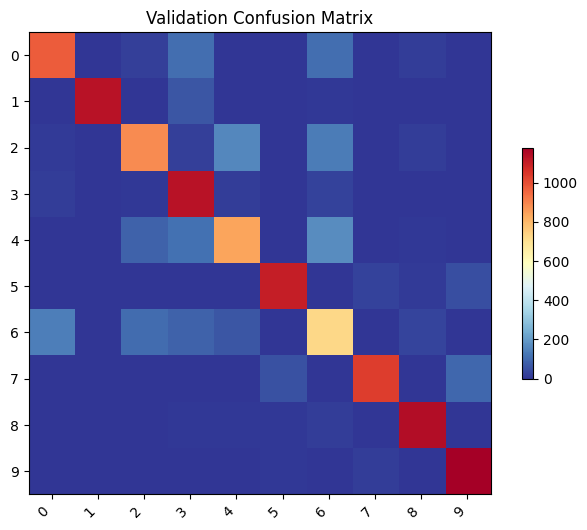


Confusion Matrices:
Training:
      Predicted
Actual    0  1  2  3  4  5  6  7  8  9
0  [3804    4   63  406    8    0  426    0   53    0]
1  [   3 4543   24  208    5    0    8    0    3    0]
2  [  25    6 3462   73  609    0  565    0   28    0]
3  [  73    8   37 4513   56    0   98    0   11    0]
4  [   3    6  329  449 3409    0  579    0   10    0]
5  [   1    3    0    6    0 4579    0   61   15  141]
6  [ 604    4  409  299  227    0 3191    0  117    0]
7  [   0    0    0    0    0  134    0 4322    9  355]
8  [   7    2   19   21   10    5   48    3 4704    1]
9  [   0    2    0    2    0   15    0   48    7 4722]

Validation:
      Predicted
Actual    0  1  2  3  4  5  6  7  8  9
0  [975   0  23 109   4   0 107   0  18   0]
1  [   2 1129    4   64    0    0    5    0    2    0]
2  [ 12   0 884  20 160   0 138   0  18   0]
3  [  16    1    9 1130   17    0   27    0    3    1]
4  [  0   4  85 113 839   0 168   0   6   0]
5  [   3    1    0    1    0 1104    1   26   10   

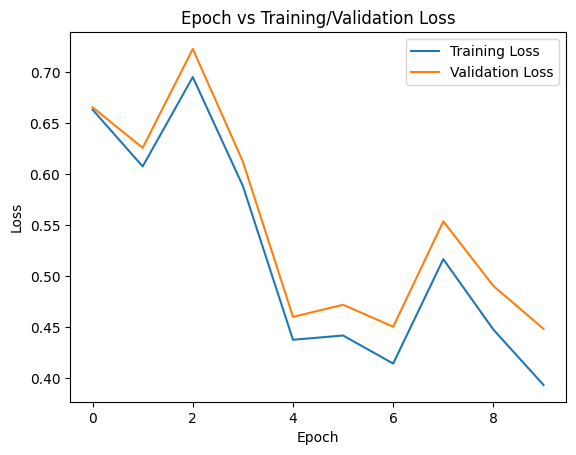

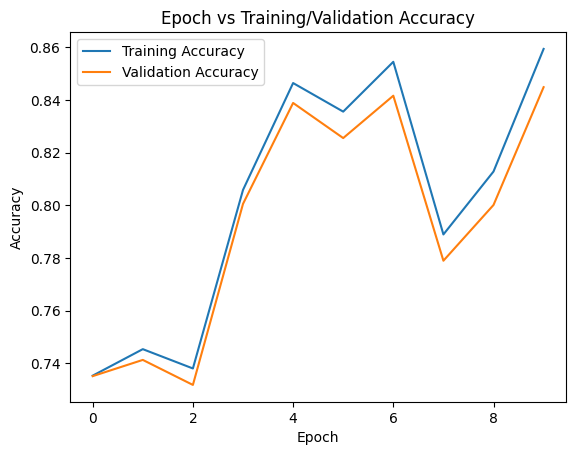

In [ ]:
# ==========================================================
# MLP - Model Training and Testing
# ==========================================================

# define the MLP architecture
input_size = 28 * 28
hidden_size = 128
output_size = 10

# create the instance of MLP
mlp = MLP()
mlp.add_layer(DenseLayer(input_size, hidden_size, 'relu'))      #reg_type="L2" does not help
mlp.add_layer(DenseLayer(hidden_size, output_size, 'softmax'))  #reg_type="L2" does not help

logger.info("Training the classification MLP model")

# Training and validating standalone MLP model
mlp.train(train_data__np, train_labels__np, val_data__np, val_labels__np)
# Testing standalone MLP model
mlp.test(test_images__np, test_labels__np)

# Evaluate on the training and validation sets
y_pred_train = mlp.predict(train_data__np)
y_pred_val = mlp.predict(val_data__np)

# Calculate accuracy, recall, sensitivity (same as recall), and F1 score
train_accuracy = accuracy_score(train_labels__np, y_pred_train)
train_recall = recall_score(train_labels__np, y_pred_train, average='weighted')  # Weighted recall for multi-class
train_f1 = f1_score(train_labels__np, y_pred_train, average='weighted')  # Weighted F1 score for multi-class

val_accuracy = accuracy_score(val_labels__np, y_pred_val)
val_recall = recall_score(val_labels__np, y_pred_val, average='weighted')  # Weighted recall for multi-class
val_f1 = f1_score(val_labels__np, y_pred_val, average='weighted')  # Weighted F1 score for multi-class

# Calculate confusion matrix for training and validation sets
train_cm = confusion_matrix(train_labels__np, y_pred_train)
val_cm = confusion_matrix(val_labels__np, y_pred_val)

# Print the evaluation metrics
logger.info("\nEvaluation Metrics:")
logger.info(f"Training Accuracy: {train_accuracy:.4f}")
logger.info(f"Training Recall : {train_recall:.4f}")
logger.info(f"Training F1 Score: {train_f1:.4f}")
logger.info(f"\nValidation Accuracy: {val_accuracy:.4f}")
logger.info(f"Validation Recall : {val_recall:.4f}")
logger.info(f"Validation F1 Score: {val_f1:.4f}")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap="RdYlBu_r")
    plt.colorbar(shrink=0.5)
    plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(np.arange(len(labels)), labels)
    plt.title(title)
    plt.grid(False)
    plt.show()

class_labels = np.unique(np.concatenate((train_labels__np, y_pred_train)))

plot_confusion_matrix(train_cm, np.unique(train_labels__np), "Training Confusion Matrix")
plot_confusion_matrix(val_cm, np.unique(val_labels__np), "Validation Confusion Matrix")

print("\nConfusion Matrices:")
print("Training:")
print(f"      Predicted\nActual  {''.join([f'  {label}' for label in class_labels])}")  # Print class labels horizontally
for i in range(len(train_cm)):
    print(f"{class_labels[i]}  {train_cm[i]}")  # Print actual class label and corresponding row

print("\nValidation:")
print(f"      Predicted\nActual  {''.join([f'  {label}' for label in class_labels])}")
for i in range(len(val_cm)):
    print(f"{class_labels[i]}  {val_cm[i]}")

mlp.show_plots()

In [ ]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# For Debugging - CNN Layer Output Size
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# input = torch.randn(784, 3, 3)

# # m = nn.Conv2d(392, 784, (2, 2), stride=(1, 1), padding=(1, 1))
# m = nn.MaxPool2d((2, 2))
# output = m(input)

# logger.debug(input.size(), output.size())

# CNN Model for Feature Extraction

In [ ]:
# ==========================================================
# Define Backbone CNN Model for Feature Extraction
# ==========================================================

class BackboneNeuralNetwork(nn.Module):
    """
    Build a small CNN model consisting of 5 convolution layers. Each convolution
    layer would be followed by a ReLU activation and a max pooling layer.

    Dense network with 2 layers, with a ReLU activation after first layer. This
    layer can be used ONLY when testing CNN model in isolation. After extracting
    feature from CNN model, use MLP for classification.

    NOTE: Dense network is not used, if `backbone_only` is `True`.

    REFERENCES:
        1. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        nn.Sequential()

        2. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nn.Conv2d(
            in_channels = number of layers in input images. Grayscale or monochrome images have 1 in_channels
            out_channels = number of channels in the output produced. This is a hyperparameter, which signifies the number of kernels
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None are other properties with default values
        )

        3. https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        nn.ReLU()

        4. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        nn.MaxPool2d(
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False are other properties with default values
        )

        5. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        nn.Linear(
            in_features = size of each input sample
            out_features = size of each output sample
            bias=True, device=None, dtype=None are other properties with default values
        )

        6. https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax
        nn.Softmax()

        7. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        Training a Classifier
    """

    # Constructor for the CNN Model.
    #
    # NOTE: If `backbone_only` is `True`, dense network is not used.
    def __init__(self, backbone_only=False):
        super().__init__()

        # this property helps the CNN transition from a full-fledged network to a backbone CNN
        # the default value is False - meaning an object of this class can be used to predict the labels for Fashion-MNIST dataset
        # if the value is set to True - an object of this class will return the flattened output from conv layers - thus acting as a backbone
        self.backbone_only = backbone_only

        self.flatten = nn.Flatten()

        # CNN model consisting of 5 convolution layers with each convolution
        # layer followed by a ReLU activation and a max pooling layer.
        self.convolutional_relu_stack = nn.Sequential(
            nn.Conv2d(1, 49, (3, 3), stride=(1, 1), padding=(1, 1)),    # input = (1,28,28), output = (49, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (49, 28, 28), output = (49, 14, 14)
            nn.Conv2d(49, 98, (2, 2), stride=(1, 1), padding=(1,1)),    # input = (49, 14, 14), output = (98, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (98, 15, 15), output = (98, 7, 7)
            nn.Conv2d(98, 196, (2, 2), stride=(1, 1), padding=(1,1)),   # input = (98, 7, 7), output = (196, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (196, 8, 8), output = (196, 4, 4)
            nn.Conv2d(196, 392, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (196, 4, 4), output = (392, 5, 5)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (392, 5, 5), output = (392, 2, 2)
            nn.Conv2d(392, 784, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (392, 2, 2), output = (784, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                                        # input = (784, 3, 3), output = (784,1,1)
        )

        # Dense network with 2 layers with a ReLU activation after first layer.
        # This layer can be used ONLY when testing CNN model in isolation.
        #
        # NOTE: Dense network is not used, if `backbone_only` is `True`.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Forward pass for CNN Model
    def forward(self, x):
        logger.debug(f'CNN Input Size: {x.size()}')
        x1 = self.convolutional_relu_stack(x)
        logger.debug(f'CNN Output Size: {x1.size()}')
        x2 = self.flatten(x1)
        logger.debug(f'Flatten Size: {x2.size()}')

        if self.backbone_only:  # return the flattened tensor containing feature extraction data
            return x2

        # default behaviour is to return the predicted labels
        x3 = self.linear_relu_stack(x2)
        return x3

# CNN and MLP Combined - Model Training and Testing

INFO:root:Training the backbone CNN model
INFO:root:
Epoch 1
-------------------------------
INFO:root:loss: 2.295060  [   64/48000]
INFO:root:loss: 2.302281  [ 6464/48000]
INFO:root:loss: 2.187855  [12864/48000]
INFO:root:loss: 1.189728  [19264/48000]
INFO:root:loss: 0.919201  [25664/48000]
INFO:root:loss: 0.814130  [32064/48000]
INFO:root:loss: 0.660188  [38464/48000]
INFO:root:loss: 0.627467  [44864/48000]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
INFO:root:Validation Phase: 
 Accuracy: 68.8%, Avg loss: 0.754088 

INFO:root:
Epoch 2
-------------------------------
INFO:root:loss: 1.062004  [   64/48000]
INFO:root:loss: 0.551623  [ 6464/48000]
INFO:root:loss: 0.684894  [1286

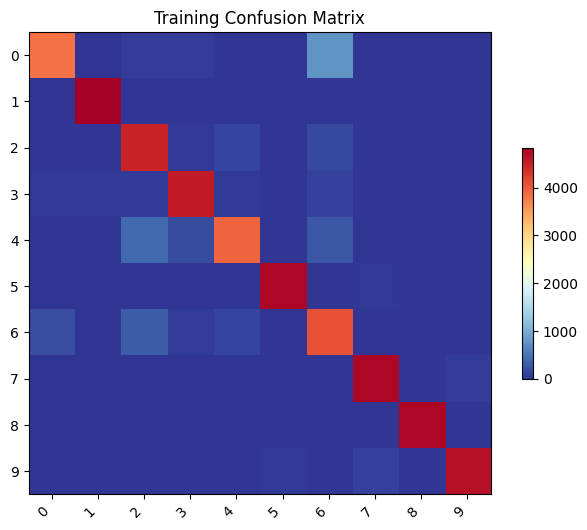

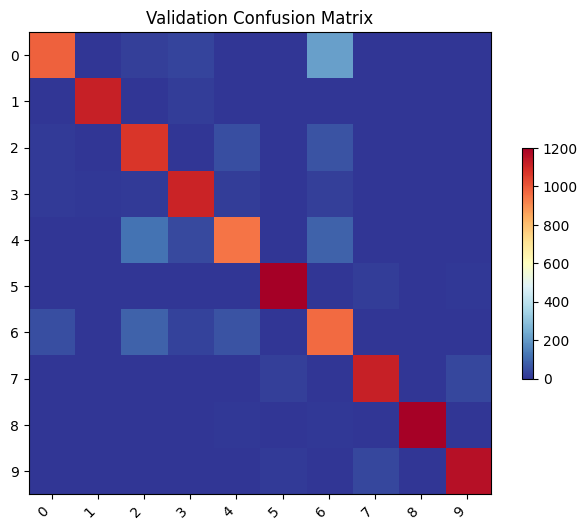


Confusion Matrices:
Training:
      Predicted
Actual    0  1  2  3  4  5  6  7  8  9
0  [3837    2   66   63    3    0  759    0   14    0]
1  [   0 4839    0   15    0    0    3    0    0    0]
2  [  13    1 4485   22  126    0  155    0    3    0]
3  [  25   21   52 4559   45    1  101    0    7    0]
4  [   1    1  410  186 3940    0  247    0   11    0]
5  [   0    0    0    0    0 4748    0   27    0    2]
6  [ 199    1  308   67  126    0 4091    0   13    0]
7  [   0    0    0    0    0   14    0 4746    0   67]
8  [   0    0    6    1    2    1   10    0 4761    0]
9  [   0    0    0    0    0   23    0  112    2 4660]

Validation:
      Predicted
Actual    0  1  2  3  4  5  6  7  8  9
0  [982   0  23  31   4   1 212   0   3   0]
1  [   1 1119    0   18    1    0    3    0    1    0]
2  [  12    2 1069    3   50    0   58    0    1    0]
3  [  13    9   13 1111   18    0   22    0    3    0]
4  [  3   2 122  41 948   0  85   0   3   0]
5  [   0    0    0    0    0 1202    0   

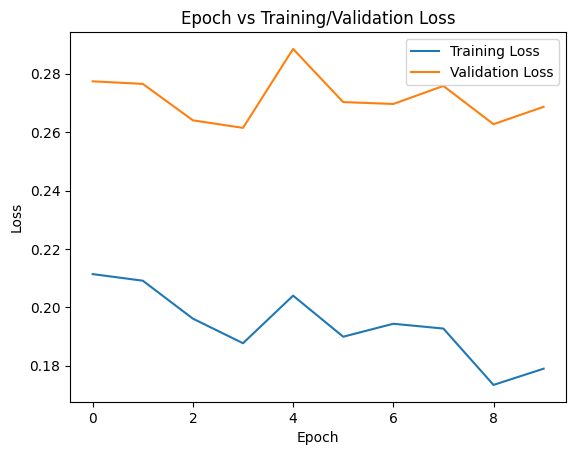

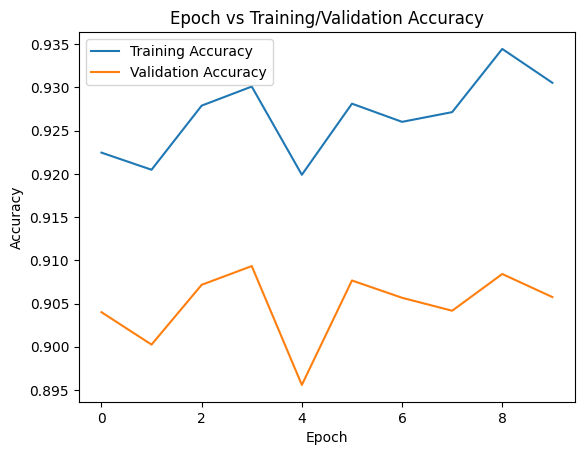

In [ ]:
# ==========================================================
# CNN and MLP Combined - Model Training and Testing
# ==========================================================

# create CNN model instance
model = BackboneNeuralNetwork().to(device)
logger.debug(model)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# forward pass implementation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            logger.info(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# validation implementation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= num_batches
    correct /= size
    logger.info(f"Validation Phase: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")

# testing implementation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    logger.info(f"Test Phase: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train and Validate the CNN
logger.info("Training the backbone CNN model")
for t in range(epochs):
    logger.info(f"\nEpoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    validate(validate_dataloader, model, loss_fn)
logger.info("Done!")

# Save the model
torch.save(model.state_dict(), "model.pth")
logger.info("Saved PyTorch CNN backbone model state to model.pth")

# Load the model to perform testing on the trained variables
model = BackboneNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Test with the model
test(test_dataloader, model, loss_fn)

#####################################
# Once the backbone model is prepared, trained, and tested,
# start the integration of backbone model with custom MLP

# define the MLP architecture
input_size = 28 * 28
hidden_size = 128
output_size = 10

# create the instance of MLP
mlp = MLP()
mlp.add_layer(DenseLayer(input_size, hidden_size, 'relu'))      #reg_type="L2" does not help
mlp.add_layer(DenseLayer(hidden_size, output_size, 'softmax'))  #reg_type="L2" does not help

# train the MLP using features extracted from pre-trained backbone
def feature_extraction(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    features = np.empty((size, 28*28), dtype=np.float64)
    labels = np.empty((size), dtype=np.int64)
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            features[(batch * batch_size):((batch + 1) * batch_size)] = pred.detach().cpu().numpy()  # extract the features in numpy arrays
            labels[(batch * batch_size):((batch + 1) * batch_size)] = y.detach().cpu().numpy()       # extract the features in numpy arrays
    return features, labels

# create the instance of `backbone CNN model`
backbone_model = BackboneNeuralNetwork(backbone_only=True).to(device)
backbone_model.load_state_dict(torch.load("model.pth"))

# extract the features using backbone CNN
classifier_train_data, classifier_train_labels = feature_extraction(train_dataloader, backbone_model)
classifier_validation_data, classifier_validation_labels = feature_extraction(validate_dataloader, backbone_model)

# let the MLP classify the data now based on feature-extracted dataset
logger.info("Training the classification MLP model")

mlp.train(classifier_train_data, classifier_train_labels, classifier_validation_data, classifier_validation_labels)

classifier_test_data, classifier_test_labels = feature_extraction(test_dataloader, backbone_model)
mlp.test(classifier_test_data, classifier_test_labels)

# Evaluate on the training and validation sets
y_pred_train = mlp.predict(classifier_train_data)
y_pred_val = mlp.predict(classifier_validation_data)

# Calculate accuracy, recall, sensitivity (same as recall), and F1 score
train_accuracy = accuracy_score(classifier_train_labels, y_pred_train)
train_recall = recall_score(classifier_train_labels, y_pred_train, average='weighted')  # Weighted recall for multi-class
train_f1 = f1_score(classifier_train_labels, y_pred_train, average='weighted')  # Weighted F1 score for multi-class

val_accuracy = accuracy_score(classifier_validation_labels, y_pred_val)
val_recall = recall_score(classifier_validation_labels, y_pred_val, average='weighted')  # Weighted recall for multi-class
val_f1 = f1_score(classifier_validation_labels, y_pred_val, average='weighted')  # Weighted F1 score for multi-class

# Calculate confusion matrix for training and validation sets
train_cm = confusion_matrix(classifier_train_labels, y_pred_train)
val_cm = confusion_matrix(classifier_validation_labels, y_pred_val)

# Show the evaluation metrics
logger.info("\nEvaluation Metrics:")
logger.info(f"Training Accuracy: {train_accuracy:.4f}")
logger.info(f"Training Recall : {train_recall:.4f}")
logger.info(f"Training F1 Score: {train_f1:.4f}")
logger.info(f"\nValidation Accuracy: {val_accuracy:.4f}")
logger.info(f"Validation Recall : {val_recall:.4f}")
logger.info(f"Validation F1 Score: {val_f1:.4f}")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap="RdYlBu_r")
    plt.colorbar(shrink=0.5)
    plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(np.arange(len(labels)), labels)
    plt.title(title)
    plt.grid(False)
    plt.show()

class_labels = np.unique(np.concatenate((train_labels__np, y_pred_train)))

plot_confusion_matrix(train_cm, np.unique(classifier_train_labels), "Training Confusion Matrix")
plot_confusion_matrix(val_cm, np.unique(classifier_validation_labels), "Validation Confusion Matrix")

print("\nConfusion Matrices:")
print("Training:")
print(f"      Predicted\nActual  {''.join([f'  {label}' for label in class_labels])}")  # Print class labels horizontally
for i in range(len(train_cm)):
    print(f"{class_labels[i]}  {train_cm[i]}")  # Print actual class label and corresponding row

print("\nValidation:")
print(f"      Predicted\nActual  {''.join([f'  {label}' for label in class_labels])}")
for i in range(len(val_cm)):
    print(f"{class_labels[i]}  {val_cm[i]}")

mlp.show_plots()